In [1]:
import tensorflow as tf
import utils
import train
import samplers
import models
import inpaint
import visualize
import absl
import numpy as np
import absl
import matplotlib.pyplot as plt

#absl.app.flags.DEFINE_string('f', '', 'kernel')

# Execution settings

In [2]:
retrain_models = False
rerun_samplers = True
create_vis     = False
eval_coverage  = False

# MNIST

## Train models

In [3]:
VAE_EPOCHS = 1000
GAN_EPOCHS = 200

### Train VAE

In [4]:
data_path  = '../../data/mnist.npy'
model_spec = '../model_specs/vae_mnist.json'
if retrain_models:
    vae_model = train.train(data_path, model_spec, epochs=VAE_EPOCHS)
    vae_model.plot_sample()

### Train GAN

In [5]:
data_path  = '../../data/mnist.npy'
model_spec = '../model_specs/gan_mnist.json'
if retrain_models:
    gan_model = train.train(data_path, model_spec, epochs=GAN_EPOCHS)
    gan_model.plot_sample()

## Run samplers

### Show test image

In [6]:
test_path  = '../data/datasets/test/mnist_100.npy'
test_image = np.load(test_path, allow_pickle=True)


In [9]:
n_samples_per_image = 1
save_interval = 5
'''inpaint_settings = {'opt':{'save_interval':save_interval,'noise_sd':0.1,'noise_decay':0.0001, 'use_metropolis':False, 'n_samples':n_samples_per_image, 'iterations':20000,'optimizer':'adam','learning_rate':0.0001},
                   'ld'  :{'save_interval':save_interval,'noise_sd':0.1, 'noise_decay':0.0, 'use_metropolis':False,'iterations':10000,'n_samples':n_samples_per_image},
                   'mala':{'save_interval':save_interval,'noise_sd':0.1, 'noise_decay':0.0, 'use_metropolis':True, 'iterations':10000,'n_samples':n_samples_per_image},
                   'mh'  :{'save_interval':save_interval,'noise_sd':0.1, 'noise_decay':0.0, 'use_metropolis':True, 'iterations':10000,'n_samples':n_samples_per_image, 'skip_grad':True}}'''
inpaint_settings = {'opt':{'save_interval':save_interval,'noise_sd':0.1,'noise_decay':0.0001, 'use_metropolis':False, 'n_samples':n_samples_per_image, 'iterations':20000,'optimizer':'adam','learning_rate':0.0001}}

'''generator_paths = {'gan':'../data/saved_models/gan_mnist_generative_net.h5',
                  'vae':'../data/saved_models/vae_mnist_generative_net.h5'}     '''          

generator_paths = {'vae':'../data/saved_models/vae_mnist_generative_net.h5'}
#samples = {'gan':{},'vae':{}}
samples = {'vae':{}}

### Run inpainting methods

In [10]:
import importlib
if rerun_samplers:
    inpaint_spec_path = '../inpaint_specs/test_spec.json'
    for gen_name,path in generator_paths.items():    
        for method_name,setting in inpaint_settings.items(): 
            setting['apply_tiling'] = True
            if gen_name is 'gan':
                setting['from_logits'] = False
            elif gen_name is 'vae':
                setting['from_logits'] = True

            # Hack to avoid Tensorflow error in reloading
            # graph-mode decorated function
            for module in [samplers, inpaint, utils, visualize]:
                importlib.reload(module)

            save_name = '_'.join([gen_name,method_name,'samples.npy'])
            zs,loss_history = inpaint.inpaint(path, 
                                             inpaint_spec_path,
                                             test_path,
                                             save=True,
                                             save_name=save_name,
                                             **setting)
            samples[gen_name][method_name] = zs

Loss: 7.2755: 100%|██████████| 20000/20000 [03:59<00:00, 83.52it/s]


In [17]:
np.mean(test.mask)

0.9681122448979592

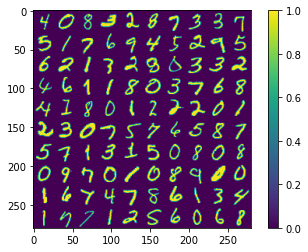

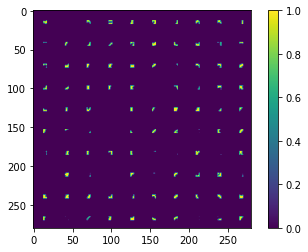

In [19]:
test = np.load(test_path, allow_pickle=True)
flat_test = utils.flatten_image_batch(test.data.squeeze(),10,10)
plt.imshow(flat_test); plt.colorbar()
plt.figure()
flat_mask = utils.flatten_image_batch(test.mask.squeeze(),10,10)
plt.imshow((1-flat_mask) * flat_test); plt.colorbar()

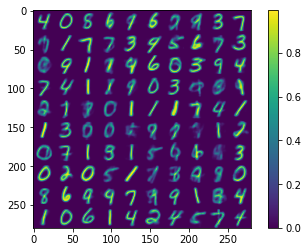

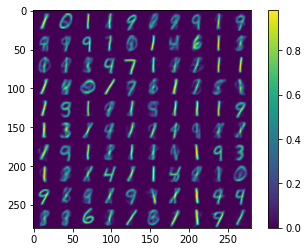

In [11]:
dgm = 'vae'

flat = utils.flatten_image_batch(samples[dgm]['opt'][-1].squeeze(),10,10)
plt.imshow(flat); plt.colorbar()
plt.figure()
flat = utils.flatten_image_batch(samples[dgm]['opt'][0].squeeze(),10,10)
plt.imshow(flat); plt.colorbar()

## Save inpainting progress GIFs

In [ ]:
import os
samples_dir = '../data/samples/'
extension = '.npy'

importlib.reload(visualize)

if create_vis:
    for fp in os.listdir(samples_dir):
        if extension in fp:
            prefix = fp.split(extension)[0]
            visualize.samples2gif(samples_dir+fp,
                                  f'../data/visualizations/{prefix}.gif',
                                  6,6,fps=5,
                                 masked_picture_path=test_path)



## Evaluate coverages

In [24]:
samples_path = '../data/samples/vae_opt_samples.npy'
test_path    = '../data/datasets/test/mnist_100.npy'
chains  = np.load(samples_path)
samples = chains[-1]
true    = np.load(test_path, allow_pickle=True).data

In [53]:
from functools import partial

func_samples  = partial(np.mean,axis=(2,3,4))
func_true     = partial(np.mean,axis=(1,2,3))

width=90

def interval_bounds(width):
    low = int((100-width) / 2)
    high = width + low
    return low, high

def coverage_with_func(samples, true, func_samples, func_true, width=90):
    bounds = interval_bounds(width)
    sample_vals  = func_samples(samples)
    true_vals    = func_true(true)
    low, high    = np.percentile(sample_vals,q=bounds,axis=0)
    coverage_rate = np.logical_and(high > true_vals, low < true_vals).mean()
    return coverage_rate

In [55]:
print(coverage_with_func(chains, true, func_samples, func_true))

0.2
